## Imports

In [8]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Importando nossas funções modularizadas
from src.data_processing import load_data, preprocess_data
from src.model import build_cnn_model
from src.evaluation import plot_history, plot_confusion_matrix

%matplotlib inline

In [9]:
# Caminhos para os dados
TRAIN_PATH = 'data/raw/train.csv'
TEST_PATH = 'data/raw/test.csv'

# Parâmetros do modelo
EPOCHS = 30 # Aumentado para um resultado melhor
BATCH_SIZE = 86

In [10]:
train_df, test_df = load_data(TRAIN_PATH, TEST_PATH)

Dados carregados com sucesso.


## Análise Exploratória de Dados (EDA)
Vamos verificar a distribuição das classes e a presença de valores nulos.

Verificando valores nulos no treino: False
Verificando valores nulos no teste: False


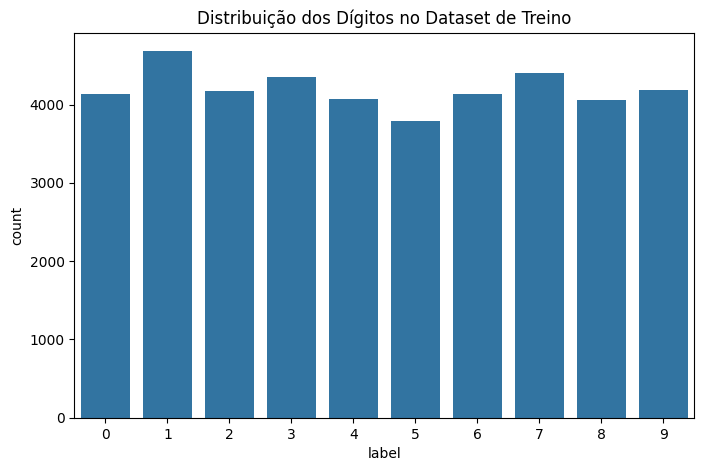

In [11]:
if train_df is not None:
    print("Verificando valores nulos no treino:", train_df.isnull().sum().any())
    print("Verificando valores nulos no teste:", test_df.isnull().sum().any())
    
    plt.figure(figsize=(8, 5))
    sns.countplot(x='label', data=train_df)
    plt.title('Distribuição dos Dígitos no Dataset de Treino')
    plt.show()

In [12]:
X_train, X_val, Y_train, Y_val, test = preprocess_data(train_df, test_df)

Pré-processamento concluído.


## Construção e Compilação do Modelo CNN

In [13]:
model = build_cnn_model()

optimizer = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)

model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

/home/joao/KaggleProjects/digit_recognizer/venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
W0000 00:00:1753214766.855600  360027 gpu_device.cc:2341] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Modelo CNN construído.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │        25,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3136)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       803,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 887,530 (3.39 MB)

 Trainable params: 887,530 (3.39 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# Callback para reduzir a taxa de aprendizado quando a acurácia de validação estagnar
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

# Gerador de imagens para Data Augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=False,
    vertical_flip=False
)

datagen.fit(X_train)

## Treinamento do Modelo

In [ ]:
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_val, Y_val),
    verbose=2,
    steps_per_epoch=X_train.shape[0] // BATCH_SIZE,
    callbacks=[learning_rate_reduction]
)

Epoch 1/30


/home/joao/KaggleProjects/digit_recognizer/venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


## Avaliação do Modelo

In [ ]:
plot_history(history)

In [ ]:
# Predições no conjunto de validação
Y_pred = model.predict(X_val)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(Y_val, axis=1)

# Computar e plotar a matriz de confusão
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)
plot_confusion_matrix(confusion_mtx, classes=range(10))

## Geração do Arquivo de Submissão

In [ ]:
results = model.predict(test)
results = np.argmax(results, axis=1)
results = pd.Series(results, name="Label")

submission = pd.concat([pd.Series(range(1, 28001), name="ImageId"), results], axis=1)
submission.to_csv("submissions/submission.csv", index=False)

print("Arquivo de submissão 'submission.csv' salvo na pasta /submissions.")